# Downloading data

In [ ]:
!pip install -q opendatasets

In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/competitions/iasa-champ-24-ui-element-sketch-classification/data', force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: oleksandrabalytska
Your Kaggle Key: ··········


100%|██████████| 82.6M/82.6M [00:01<00:00, 82.5MB/s]



Extracting archive ./iasa-champ-24-ui-element-sketch-classification/iasa-champ-24-ui-element-sketch-classification.zip to ./iasa-champ-24-ui-element-sketch-classification


# Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
import seaborn as sns

import tensorflow as tf
from keras.layers import *
from keras import Model
from keras.optimizers import *

In [ ]:
tf.__version__

'2.15.0'

# Data overview

In [ ]:
data = pd.read_csv('/content/iasa-champ-24-ui-element-sketch-classification/predictions_example.csv')
data.head()

,ID,Target
0,079c715e-0387-4fa2-abc0-5cc7a81120f6.jpg,text_field
1,a7b15b95-c998-4c3a-85c9-9eae9143c894.jpg,card
2,69123d68-e442-4cae-8f86-9c3f4c985760.jpg,data_table
3,c61abe0a-54bc-4cfd-b5bd-ccfff2e0d535.jpg,switch_enabled
4,ec5c04b8-d75f-4414-821f-6e845a6bfad3.jpg,chip


In [ ]:
train_data = '/content/iasa-champ-24-ui-element-sketch-classification/ui_icons_dataset/ui_icons_dataset/train'
classes = os.listdir(train_data)
n_classes = len(classes)

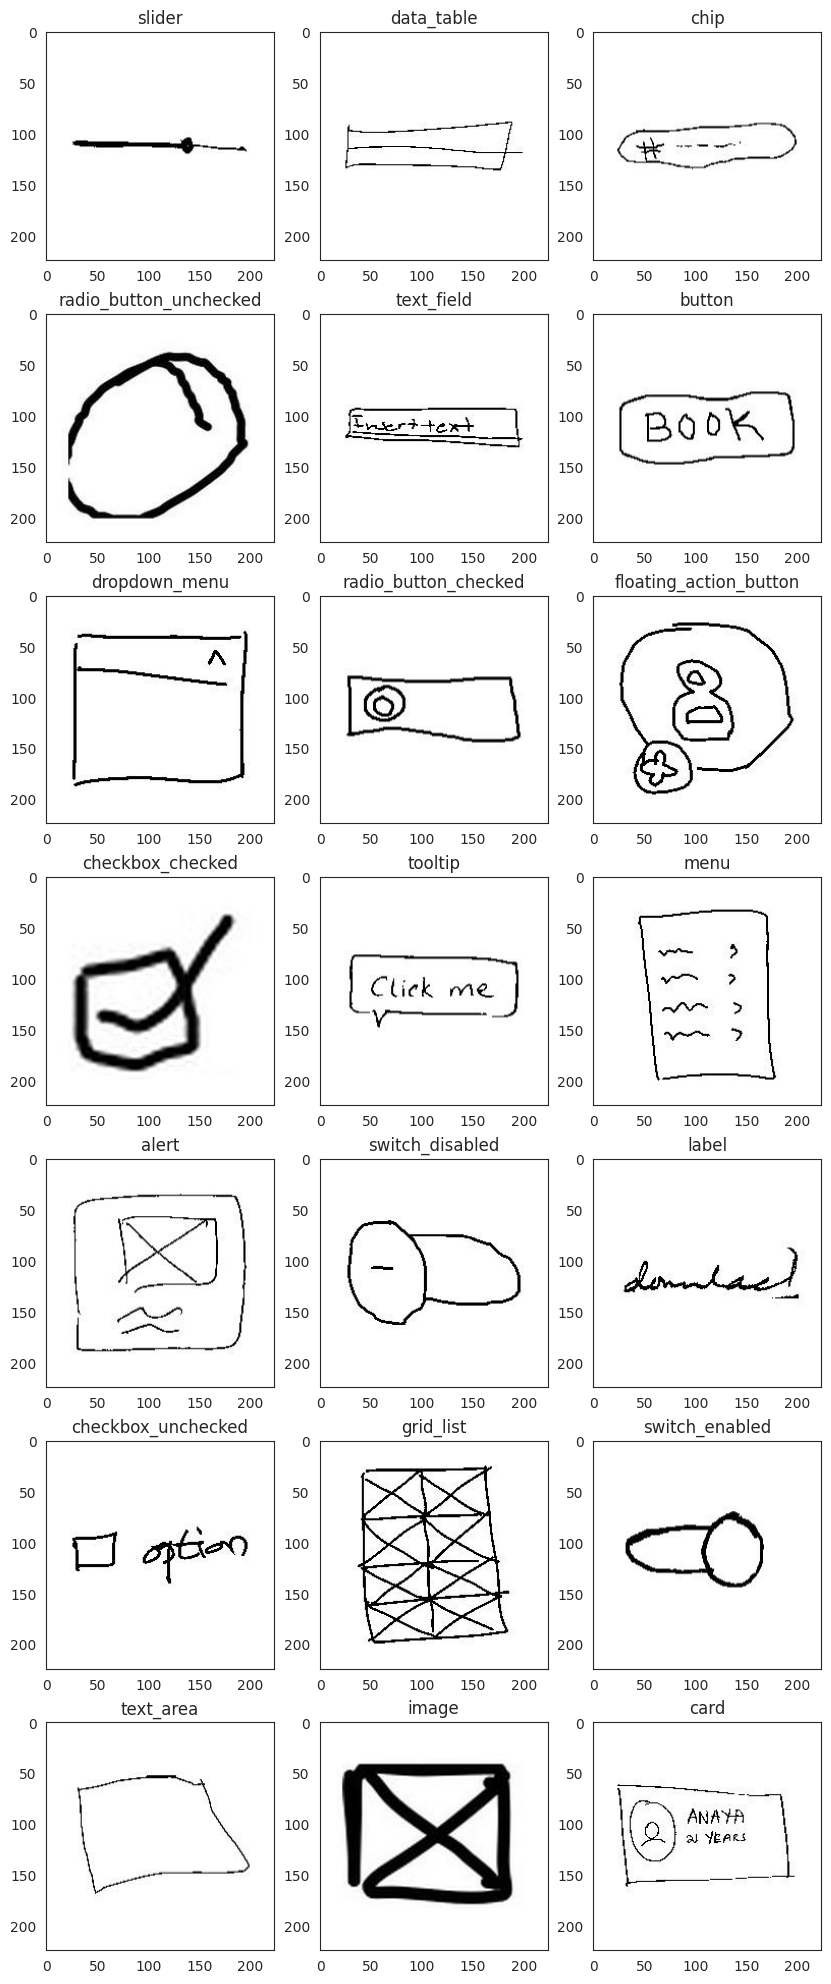

In [ ]:
sns.set_style('white')
fig, axs = plt.subplots(7, 3, figsize=(10, 25))
axs_flat = axs.flatten()

for ax, folder in zip(axs_flat, classes):
    random_num = np.random.randint(0, 600)
    imgs_path = os.path.join(train_data, folder)
    imgs = os.listdir(imgs_path)

    image_path = os.path.join(imgs_path, imgs[random_num])
    image = plt.imread(image_path)

    ax.imshow(image)
    ax.set_title(folder)

plt.show()

In [ ]:
def prepare_data(train_data, classes):
    classes_count = {}

    for folder in classes:
        class_path = os.path.join(train_data, folder)
        classes_count[folder] = len(os.listdir(class_path))

    df = pd.DataFrame(list(classes_count.items()), columns=['UI_Icon', 'Score'])
    df['Weights'] = df.Score.sum() / (df.shape[0] * df.Score)

    weights = df['Weights'].to_dict()

    return df, weights

In [ ]:
data, weights = prepare_data(train_data, classes)

# Generation data for training

In [ ]:
batch_size = 10
train_input_shape = (224, 224, 3)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
                                  )


In [ ]:
train_generator = train_datagen.flow_from_directory(directory=train_data,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=data['UI_Icon'].tolist(),
                                                    seed=42
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=train_data,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=data['UI_Icon'].tolist(),
                                                    seed=42
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 12325 images belonging to 21 classes.
Found 3074 images belonging to 21 classes.
Total number of batches = 1232 and 307


# CNN Tests

In [ ]:
base_model2 = tf.keras.applications.MobileNet(input_shape=(224, 224,3), alpha=1., weights='imagenet', include_top = False)
inp = base_model2.input
x = base_model2.output
x = GlobalAveragePooling2D()(x)
x = Dense(21, activation='softmax')(x)

model2 = Model(inp, x)

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
optimizer = Adam(learning_rate=0.0001)
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [ ]:
history = model2.fit(train_generator,
                     epochs=20,
                     steps_per_epoch = STEP_SIZE_TRAIN,
                     validation_data = valid_generator,
                     validation_steps = STEP_SIZE_VALID,
                    class_weight=weights)

Epoch 1/20
1232/1232 [==============================] - 51s 33ms/step - loss: 3.7740 - accuracy: 0.0898 - val_loss: 2.8017 - val_accuracy: 0.1283
Epoch 2/20
1232/1232 [==============================] - 40s 32ms/step - loss: 3.0857 - accuracy: 0.1299 - val_loss: 2.2395 - val_accuracy: 0.3003
Epoch 3/20
1232/1232 [==============================] - 40s 32ms/step - loss: 2.5960 - accuracy: 0.2100 - val_loss: 2.0462 - val_accuracy: 0.3603
Epoch 4/20
1232/1232 [==============================] - 40s 32ms/step - loss: 2.3447 - accuracy: 0.2777 - val_loss: 2.7535 - val_accuracy: 0.1655
Epoch 5/20
1232/1232 [==============================] - 40s 33ms/step - loss: 2.1051 - accuracy: 0.3489 - val_loss: 2.5705 - val_accuracy: 0.2476
Epoch 6/20
1232/1232 [==============================] - 40s 32ms/step - loss: 1.9212 - accuracy: 0.4093 - val_loss: 1.6703 - val_accuracy: 0.5013
Epoch 7/20
1232/1232 [==============================] - 40s 32ms/step - loss: 1.7333 - accuracy: 0.4704 - val_loss: 1.8485 -

In [ ]:
def plot_loss_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()


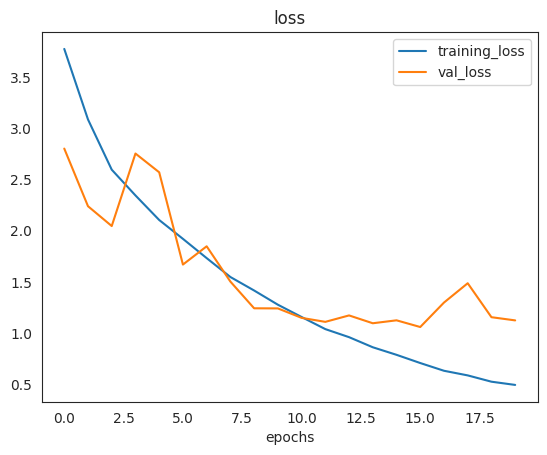

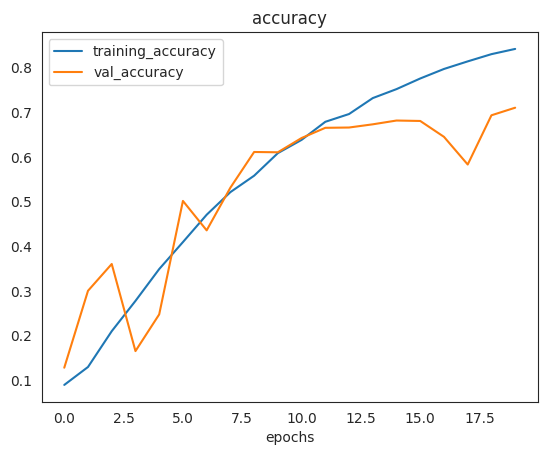

In [ ]:
plot_loss_curves(history)

In [ ]:
score = model2.evaluate(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])
score = model2.evaluate(valid_generator, verbose=1)
print("Prediction accuracy on CV data =", score[1])

1233/1233 [==============================] - 16s 13ms/step - loss: 0.0114 - accuracy: 0.9966
Prediction accuracy on train data = 0.9965922832489014
308/308 [==============================] - 4s 14ms/step - loss: 0.8005 - accuracy: 0.8556
Prediction accuracy on CV data = 0.8555628061294556


# Test Part

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0
    return img

In [ ]:
import os

test_images_directory = '/content/iasa-champ-24-ui-element-sketch-classification/ui_icons_dataset/ui_icons_dataset/test'
test_image_files = [f for f in os.listdir(test_images_directory) if f.endswith('.jpg')]
len(test_image_files)

5143

In [ ]:
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'dropdown_menu',
 1: 'menu',
 2: 'switch_enabled',
 3: 'checkbox_unchecked',
 4: 'alert',
 5: 'image',
 6: 'tooltip',
 7: 'button',
 8: 'radio_button_unchecked',
 9: 'data_table',
 10: 'radio_button_checked',
 11: 'floating_action_button',
 12: 'text_field',
 13: 'card',
 14: 'text_area',
 15: 'slider',
 16: 'chip',
 17: 'switch_disabled',
 18: 'label',
 19: 'checkbox_checked',
 20: 'grid_list'}

In [ ]:
%%time

results = []
for image in test_image_files:
    img_path = os.path.join(test_images_directory, image)
    img = preprocess_image(img_path)
    prediction = model2.predict(img)
    label = labels[np.argmax(prediction)]
    results.append((image, label))

1/1 [==============================] - 0s 19ms/step
CPU times: user 5min 51s, sys: 14.2 s, total: 6min 6s
Wall time: 5min 52s


In [ ]:
len(results)

In [ ]:
import csv

output_file = 'result.csv'

with open(output_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'Target'])
    for result in results:
        writer.writerow(result)

In [ ]:
test_1 = pd.read_csv('/content/result.csv')
test_1.head()